In [114]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import re
import nltk
import string
import math

from matplotlib.colors import ListedColormap
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

# Phase 0 : Exploratory Data Analysis

In [122]:
df = pd.read_csv("spam.csv", encoding = "ISO-8859-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [123]:
# We drop the redundent looking columns
unuseful = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
df = df.drop(df[unuseful], axis=1)

# We rename the columns in order to make them more understandable
df.rename(columns = {"v1": "Target", "v2": "Text"}, inplace = True)
df.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [136]:
print(df['Text'][10])
print(df['Text'][8])

I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.
WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.


Plot something useful. Taken from [here](https://www.kaggle.com/karnikakapoor/spam-or-ham-sms-classifier)

Ham: 4825 
Spam: 747


Text(0, 0.5, 'Number of Data points')

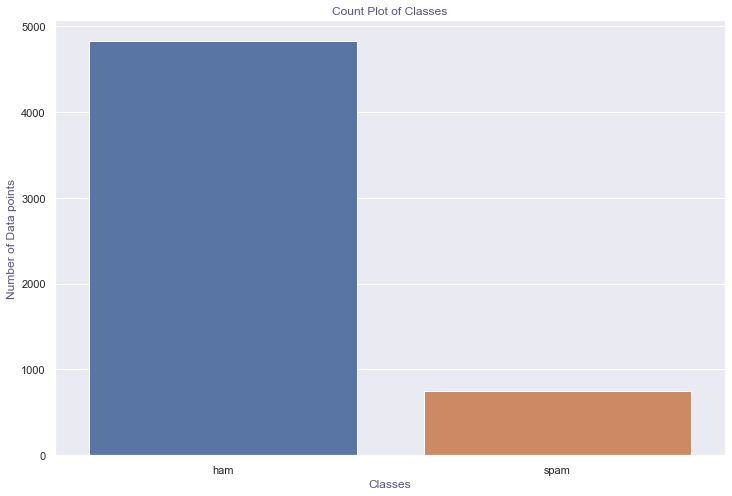

In [44]:
sns.set_theme()
print('Ham:', len(df[df['Target'] == 'ham']), '\nSpam:', len(df[df['Target'] == 'spam']))

plt.figure(figsize=(12,8))
fg = sns.countplot(x = df["Target"])
fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d")

In [45]:
data = df

#Adding a column of numbers of charachters,words and sentences in each msg
data["No_of_Characters"] = data["Text"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
data["No_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)

data.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_Words,5572.0,18.698492,13.737477,1.0,9.0,15.0,27.0,220.0
No_of_sentence,5572.0,1.991565,1.501427,1.0,1.0,1.5,2.0,38.0


<Figure size 864x576 with 0 Axes>

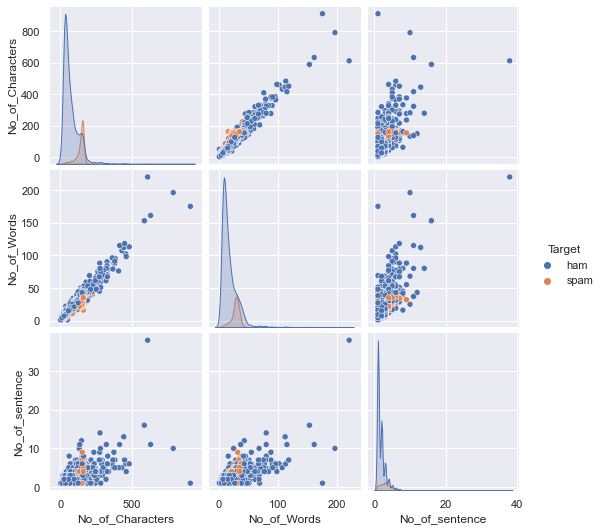

In [40]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target")
plt.show(fg)

# Phase 1: Data Preprocessing

In order to further process the data, we need to make the data cleaner.

In the first step we extract only the alphabetic characters, so we remove punctuation and numbers. Then we convert all the characters into lowercase.

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dcacc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [47]:
# pre-process a text : clean, tokenize and stem each word in text
def pre_processing(text):
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Removing punctuation, lowercase the text, removing stopwords, map punctuation to space
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    p_text = text.translate(translator).lower()
    ppt = ""
    
    for word in p_text.split():
        if word not in stopwords.words('english'):
            ppt += word + " "
    text = ppt.strip(" ")
    token_words = word_tokenize(text)
    lem_sentence = []
    
    for word in token_words:
        lem_sentence.append(lemmatizer.lemmatize(word, pos ='v'))
    return ' '.join(lem_sentence)

df["Pre_processed_text"] = df["Text"].apply(pre_processing)

In [48]:
# It creates a set for all the words
bag_words = set()
for sms in df["Pre_processed_text"]:
    for w in sms.split(" "):
        if w != "":
            bag_words = bag_words.union({w})
  
# Create a list of the words <- our corpus of words
bag = list(bag_words)

# Phase 2: Extracting the Features

In [49]:
# It returns a list of words for each sms
def split_words(text, bag_words):
    return text.split(" ")

In [50]:
df["Words"] = df["Pre_processed_text"].apply(split_words, args = (bag_words,))

In [51]:
bag_len = len(bag) # Number of words in the bag # Size of the corpus

# Vectorize each sms, assign 1 every time a specific word is in the sms
def vectorize_sms(words):
    vector = np.zeros(bag_len, dtype = "int64")
    
    for i in range(bag_len):
        if bag[i] in words:
            vector[i] += 1
            
    return vector

In [52]:
df["Vector"] = df["Words"].apply(vectorize_sms)
df 

,Target,Text,No_of_Characters,No_of_Words,No_of_sentence,Pre_processed_text,Words,Vector
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni,"[ok, lar, joke, wif, u, oni]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry 2 wkly comp win fa cup final tkts 2...,"[free, entry, 2, wkly, comp, win, fa, cup, fin...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say early hor u c already say,"[u, dun, say, early, hor, u, c, already, say]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think go usf live around though,"[nah, think, go, usf, live, around, though]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,35,4,2nd time try 2 contact u u å£750 pound prize 2...,"[2nd, time, try, 2, contact, u, u, å£750, poun...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5568,ham,Will Ì_ b going to esplanade fr home?,37,9,1,ì b go esplanade fr home,"[ì, b, go, esplanade, fr, home]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5569,ham,"Pity, * was in mood for that. So...any other s...",57,15,2,pity mood suggestions,"[pity, mood, suggestions]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5570,ham,The guy did some bitching but I acted like i'd...,125,27,1,guy bitch act like interest buy something else...,"[guy, bitch, act, like, interest, buy, somethi...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Create a dataframe ready for the analysis. It has the sms (documents) on the row and the words (features) on the columns. 
This dataframe counts the words in the sms.

In [55]:
# Initialize the dataframe
X = np.zeros((len(df), bag_len), dtype = "int64")

# For each sms consider its vectorized form
for i in range(len(df)):
    X[i] += df.iloc[i, 7]
    
# Create a pandas Dataframe    
pd.DataFrame(X, columns = bag)

,ccna,kanji,team,uh,thts,stressfull,praps,nike,077xxx,ingredients,...,09111030116,valid12hrs,outreach,mittelschmertz,guoyang,fill,hari,somewhr,question,management
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# Create the classes encoding the 'spam' and 'ham' information
'''
If a sms is ham == 0;
if a sms is spam == 1
'''

y = np.zeros(len(df), dtype="int64")

for i in range(len(df["Target"])):
    if df.iloc[i,0] == "ham":
        y[i] = 0
    else:
        y[i] = 1

# Phase 3: Model Building

In [57]:
# Splitting the test and training set
# We decided to consider the 20% of the dataset as test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, y_train.shape

((4457, 7644), (4457,))

In [58]:
N_yi = np.zeros((2, bag_len)) # feature count
N_y = np.zeros((2)) # total count 
for i in range(len(y_train)):
    # Compute N_y counting the features for each specific class
    N_y[y_train[i]] += np.sum(X_train[i])
    # Compute N_yi adding counting the specific words in each class
    N_yi[y_train[i]] += (X_train[i])
print(N_yi)

[[ 1.  1.  4. ...  1. 20.  1.]
 [ 0.  0.  2. ...  0.  9.  0.]]


## Prior 

In [59]:
P = np.zeros(2)
classes = np.unique(y_train)

# Implement Prior Probability P(A)
for j in classes:
    P[j] = np.count_nonzero(y_train == j)/(len(y_train))
    
print(P)

[0.8660534 0.1339466]


## Likelihood

In [60]:
# The likelihood of each word to be in a ham or in a spam message
likelihood_matrix_words = np.zeros((2,bag_len))

for i in range(bag_len):
    for j in range(2):
        # NOTE: We implemented Laplace Smoothing
        likelihood_matrix_words[j][i]=float((N_yi[j][i] + 1)/(N_y[j] + bag_len))
        
likelihood_matrix_words = pd.DataFrame(likelihood_matrix_words, columns = bag)

In [61]:
likelihood_matrix_words

,ccna,kanji,team,uh,thts,stressfull,praps,nike,077xxx,ingredients,...,09111030116,valid12hrs,outreach,mittelschmertz,guoyang,fill,hari,somewhr,question,management
0,0.000054,0.000054,0.000134,0.000054,0.000161,0.000054,0.000054,0.000054,0.000027,0.000054,...,0.000027,0.000027,0.000054,0.000054,0.000027,0.000241,0.000054,0.000054,0.000562,0.000054
1,0.000056,0.000056,0.000167,0.000056,0.000056,0.000056,0.000056,0.000056,0.000111,0.000056,...,0.000111,0.000167,0.000056,0.000056,0.000056,0.000056,0.000056,0.000056,0.000557,0.000056


In [66]:
# Likelihood matrix for each sms
likelihood_matrix = np.zeros((len(X_train), 2))

for i in range(len(X_train)):
    tmp_spam = []
    tmp_ham = []
    sms = X_train[i] #list of words
    
    # NOTE: In order to have numerical stability, we opted for using the logarithms
    # This way we convert all the products into sums
    for index in range(len(sms)): #for each word in sms
        if sms[index]!=0:
            weight_ham, weight_spam = likelihood_matrix_words.iloc[:, index]
            tmp_spam.append(math.log(weight_spam)**sms[index])
            tmp_ham.append(math.log(weight_ham)**sms[index])
            
    likelihood_matrix[i][0] = float(np.sum(tmp_ham))
    likelihood_matrix[i][1] = float(np.sum(tmp_spam))

In [67]:
likelihood_matrix_df = pd.DataFrame(likelihood_matrix, columns = ["ham", "spam"])

In [68]:
likelihood_matrix_df

,ham,spam
0,-54.434155,-62.207409
1,-137.468846,-123.164313
2,-47.935712,-50.348928
3,-46.803153,-56.129671
4,-180.748513,-142.225845
...,...,...
4452,-53.888084,-66.716916
4453,-16.839779,-22.429726
4454,-50.434432,-57.382434
4455,-29.822265,-35.846948


In [69]:
# Add the log of the prior probabilities
likelihood_final = np.zeros((len(X_train), 2))

for i in range(len(X_train)):
    for j in range(2):
        likelihood_final[i][j] = likelihood_matrix[i][j] + math.log(P[j])

likelihood_final = pd.DataFrame(likelihood_final, columns = ["ham", "spam"])
likelihood_final

,ham,spam
0,-54.577964,-64.217723
1,-137.612654,-125.174627
2,-48.079520,-52.359242
3,-46.946962,-58.139986
4,-180.892322,-144.236159
...,...,...
4452,-54.031893,-68.727230
4453,-16.983588,-24.440040
4454,-50.578241,-59.392749
4455,-29.966074,-37.857262


In [71]:
prob_spam = abs(likelihood_final['spam']) / (abs(likelihood_final['spam']) + abs(likelihood_final['ham']))

In [72]:
prob_spam

0       0.540573
1       0.476334
2       0.521305
3       0.553256
4       0.443628
          ...   
4452    0.559854
4453    0.590002
4454    0.540077
4455    0.558175
4456    0.568335
Length: 4457, dtype: float64

In [73]:
# Take the max value between the two log-likelihoods to predict the label
res = likelihood_final.idxmax(axis = 1)

# Replace 'ham' with 0 and 'spam' with 1
res = res.replace("ham", 0)
res = res.replace("spam", 1)

res

0       0
1       1
2       0
3       0
4       1
       ..
4452    0
4453    0
4454    0
4455    0
4456    0
Length: 4457, dtype: int64

In [74]:
confusion_matrix(y_train, res)

array([[3852,    8],
       [  17,  580]], dtype=int64)

###### x Simone: se vuoi vedere qualcosa per il threshold

In [ ]:
fpr, tpr, threshold = roc_curve(y_train, 1 - likelihood_matrix['prob_spam'])

In [ ]:
auc(fpr, tpr)

In [ ]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Naive Bayes')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

####

Now, consider X_test, repeat the same steps as before

In [75]:
likelihood_matrix_test = np.zeros((len(X_test), 2))

for i in range(len(X_test)):
    tmp_spam = []
    tmp_ham = []
    sms = X_test[i] #list of sms in X_TEST
    for index in range(len(sms)): #for each word in sms
        if sms[index] != 0:           
                weight_ham, weight_spam = likelihood_matrix_words.iloc[:, index]
                tmp_spam.append(math.log(weight_spam)**sms[index])
                tmp_ham.append(math.log(weight_ham)**sms[index])
    likelihood_matrix_test[i][0] = float(np.sum(tmp_ham))
    likelihood_matrix_test[i][1] = float(np.sum(tmp_spam))

In [76]:
likelihood_matrix_test_df = pd.DataFrame(likelihood_matrix_test, columns = ["ham", "spam"])

In [77]:
# Add the log of the prior probabilities
likelihood_final_test = np.zeros((len(X_test), 2))

for i in range(len(X_test)):
    for j in range(2):
        likelihood_final_test[i][j] = likelihood_matrix_test[i][j] + math.log(P[j])

likelihood_final_test = pd.DataFrame(likelihood_final_test, columns = ["ham", "spam"])
likelihood_final_test

,ham,spam
0,-170.514090,-175.519219
1,-151.965611,-156.268451
2,-82.402432,-73.924771
3,-55.338686,-70.475702
4,-193.566763,-142.435834
...,...,...
1110,-101.494611,-124.218596
1111,-69.087629,-76.561957
1112,-42.615097,-50.519280
1113,-13.320519,-16.500024


In [79]:
prob_spam_test = abs(likelihood_final_test['spam']) / (abs(likelihood_final_test['spam']) + abs(likelihood_final_test['ham']))

In [80]:
prob_spam_test

0       0.507232
1       0.506980
2       0.472885
3       0.560156
4       0.423913
          ...   
1110    0.550338
1111    0.525659
1112    0.542434
1113    0.553311
1114    0.456445
Length: 1115, dtype: float64

In [83]:
# Take the max value between the two log-likelihoods to predict the label
res_test = likelihood_final_test.idxmax(axis = 1)

# Replace 'ham' with 0 and 'spam' with 1
res_test = res_test.replace("ham", 0)
res_test = res_test.replace("spam", 1)

res_test

0       0
1       0
2       1
3       0
4       1
       ..
1110    0
1111    0
1112    0
1113    0
1114    1
Length: 1115, dtype: int64

In [92]:
cm = confusion_matrix(y_test, res_test)
cm

array([[955,  10],
       [ 12, 138]], dtype=int64)

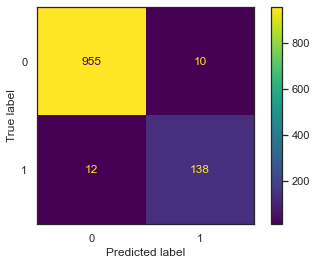

In [137]:
sns.set_theme(style="white")
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [98]:
print(classification_report(y_test, res_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       965
           1       0.93      0.92      0.93       150

    accuracy                           0.98      1115
   macro avg       0.96      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



#### x Simone: qui per il threshold

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, res)

In [ ]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Naive Bayes')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

# Phase 4: Compare with other classifiers

Including **MultinomialNB** from *sklearn*.

In [101]:
#Testing on the following classifiers
classifiers = [MultinomialNB(),
               KNeighborsClassifier(), 
               SVC(),
              LogisticRegression()]

for cls in classifiers:
    cls.fit(X_train, y_train)

# Dictionary of pipelines and model types for ease of reference
class_dict = {0: "NaiveBayes", 1: "KNeighbours", 2: "SVC", 3: "LogisticRegression"}

In [104]:
# Cossvalidation 
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train, y_train, scoring = "accuracy")
    print("%s: %f " % (class_dict[i], cv_score.mean()))

NaiveBayes: 0.984069 
KNeighbours: 0.904644 
SVC: 0.979132 
LogisticRegression: 0.982498 


## Model evaluation

In [111]:
# Model Evaluation
# creating lists of varios scores
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = precision_score(y_test, pred_test)
    recal = recall_score(y_test, pred_test)
    #f1_s = f1_score(y_test, pred_test)
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
  
    #Appending scores
    precision.append(prec)
    recall.append(recal)
    #f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)

In [112]:
# initialise data of lists.
data = {'Precision':precision,
'Recall':recall,
#'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(data, index =["NaiveBayes", "KNeighbours", "SVC", "LogisticRegression"])

In [115]:
cmap2 = ListedColormap(["#E2CCFF", "#E598D8"])
Results.style.background_gradient(cmap = cmap2)

,Precision,Recall,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,0.932432,0.920000,0.975785,0.997083
KNeighbours,1.000000,0.360000,0.975785,0.997083
SVC,0.984127,0.826667,0.975785,0.997083
LogisticRegression,1.000000,0.820000,0.975785,0.997083
